In [29]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('../data/processed/one_year_price.csv', index_col='Date', parse_dates=True)
days_trading = 252
r = 0.05245  # risk-free rate

In [30]:
heston_params = pd.DataFrame(index=data.columns, columns=['S0', 'V0', 'kappa', 'theta', 'sigma', 'rho'])
heston_params['S0'] = data.iloc[-1,:]
log_returns = np.log(data / data.shift(1))
V0 = log_returns.var()
heston_params['V0'] = V0
heston_params

,S0,V0,kappa,theta,sigma,rho
AAPL,171.479996,0.000149,NaN,NaN,NaN,NaN
AMZN,180.380005,0.000351,NaN,NaN,NaN,NaN
EEM,41.080002,0.000085,NaN,NaN,NaN,NaN
GLD,205.720001,0.000056,NaN,NaN,NaN,NaN
JNJ,158.190002,0.000097,NaN,NaN,NaN,NaN
JPM,199.138397,0.000116,NaN,NaN,NaN,NaN
SPY,523.070007,0.000052,NaN,NaN,NaN,NaN
TSLA,175.789993,0.000904,NaN,NaN,NaN,NaN


In [32]:
def heston_variance(params, T, dt, V0):
    kappa, theta, sigma, rho = params
    variances = np.zeros(T)
    variances[0] = V0
    for t in range(1, T):
        dw_variance = np.random.normal() * np.sqrt(dt)
        variances[t] = np.maximum(variances[t-1] + kappa * (theta - variances[t-1]) * dt + sigma * np.sqrt(np.maximum(variances[t-1], 0)) * dw_variance, 0)
    return variances

def objective_function(params, historical_variances, T, dt, V0):
    model_variances = heston_variance(params, T, dt, V0)
    return np.sum((historical_variances - model_variances)**2)

def estimate_heston_params(data, stock_name):
    returns = np.log(data[stock_name] / data[stock_name].shift(1)).dropna()
    historical_variances = returns.rolling(window=30).var()  # 30-day rolling variance
    historical_variances = historical_variances.dropna()

    T = len(historical_variances)
    dt = 1/252  # assuming daily data, 252 trading days in a year
    V0 = historical_variances.iloc[0]  # initial variance estimate from the first available data point

    # Initial parameter guesses: kappa, theta, sigma, rho
    initial_params = [0.5, historical_variances.mean(), 0.2, -0.5]
    bounds = [(0.01, 2), (0.0001, 0.01), (0.01, 1), (-1, 1)]

    result = minimize(objective_function, initial_params, args=(historical_variances.values, T, dt, V0),
                      bounds=bounds, method='L-BFGS-B')

    return result.x  # Returns the estimated parameters

for col in heston_params.index:
    estimated_params = estimate_heston_params(data, col)
    heston_params.loc[col, "kappa":] = estimated_params

heston_params

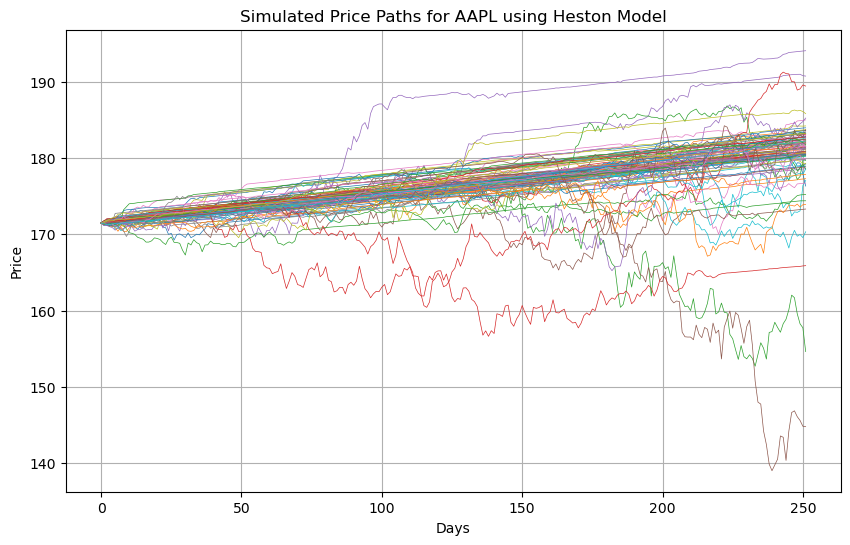

In [35]:
def heston_model_simulation(S0, V0, kappa, theta, sigma, rho, r, T=1, steps=252, Npaths=100):
    dt = T / steps
    prices = np.zeros((steps, Npaths))
    variances = np.zeros((steps, Npaths))
    prices[0, :] = S0
    variances[0, :] = V0

    for t in range(1, steps):
        dw_price = np.random.normal(size=Npaths) * np.sqrt(dt)
        dw_variance = np.random.normal(size=Npaths) * np.sqrt(dt)

        # Correlating the two Brownian motions
        dw_price = rho * dw_variance + np.sqrt(1 - rho**2) * dw_price

        # Update variance and price paths
        variances[t, :] = np.maximum(variances[t-1, :] + kappa * (theta - variances[t-1, :]) * dt + sigma * np.sqrt(variances[t-1, :]) * dw_variance, 0)
        prices[t, :] = prices[t-1, :] * np.exp((r - 0.5 * variances[t-1, :]) * dt + np.sqrt(variances[t-1, :]) * dw_price)

    return prices

# Example simulation for AAPL
r = 0.05245  # Risk-free rate
stock_name = 'AAPL'
params = heston_params.loc[stock_name]
simulated_prices = heston_model_simulation(params['S0'], params['V0'], params['kappa'], params['theta'], params['sigma'], params['rho'], r)

# Example to display the last 10 simulated price paths for AAPL
plt.figure(figsize=(10, 6))
for path in range(simulated_prices.shape[1]):
    plt.plot(simulated_prices[:, path], linewidth=0.5)
plt.title(f'Simulated Price Paths for {stock_name} using Heston Model')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [3]:
weights = {
    'AAPL': 0.3,
    'AMZN': 0.2,
    'EEM': 0.2,
    'GLD': 0.1,
    'JNJ': 0.1,
    'JPM': 0.1
}

# Function to generate a random portfolio path
def generate_random_portfolio_path(paths, weights):
    num_paths = next(iter(paths.values())).shape[1]  # Number of paths per stock
    random_path_index = random.randint(0, num_paths - 1)  # Randomly select one path index
    portfolio_path = np.zeros(paths[next(iter(paths.keys()))].shape[0])  # Initialize the portfolio path array

    for stock, weight in weights.items():
        portfolio_path += weight * paths[stock][:, random_path_index]  # Sum the weighted paths

    return portfolio_path

# Generate a random portfolio path
random_portfolio_path = generate_random_portfolio_path(paths, weights)

# Plot the random portfolio path
plt.figure(figsize=(10, 6))
plt.plot(random_portfolio_path, label='Random Portfolio Path', linewidth=2)
plt.title('Randomly Selected Portfolio Path using Heston Model')
plt.xlabel('Days')
plt.ylabel('Portfolio Price')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'kappa' is not defined